In [72]:
import numpy as np
import tensorflow as tf
# from numpy.random import seed
# seed(1)
# from tensorflow import set_random_seed
# set_random_seed(2)




import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import os
import keras
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Bidirectional, BatchNormalization,SpatialDropout1D, Activation, GlobalAveragePooling1D, Dense, Input, Dropout, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.initializers import glorot_normal, glorot_uniform, he_uniform
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.metrics import ConfusionMatrixDisplay
import random

from sklearn.utils import class_weight
from sklearn.utils import shuffle

from keras import backend as K


%matplotlib inline

import warnings
warnings.filterwarnings('ignore')



In [73]:
# Load dataset
def load_data():
  data_train=pd.read_csv('/Users/ethan/py3tf/project_nlp/train_data_hs.csv')
  data_test=pd.read_csv('/Users/ethan/py3tf/project_nlp/test_data_hs.csv')
  data_val=pd.read_csv('/Users/ethan/py3tf/project_nlp/val_data_hs.csv')
  data_train=data_train.drop('Unnamed: 0', axis=1)
  data_test=data_test.drop('Unnamed: 0', axis=1)
  data_val=data_val.drop('Unnamed: 0', axis=1)
  return data_train, data_test, data_val


In [74]:
label={0:'hate', 1:'offensive', 2:'neither'}

In [75]:
# Plot data by target class
def plot(data):
  sns.countplot(data['class'])
  plt.xlabel('Class')
  plt.title('Distribution of data in each class')
  plt.ylabel('Count')
  plt.show()

 Cleaning tweets

In [76]:
data_train, data_test, data_val = load_data()


In [77]:
data_train = data_train.astype(str)
# data_val = data_val.astype(str)

In [78]:
data_train

,class,tweet
0,0,I hate when faggots talk shit on here then b...
1,1,Dumb bitch
2,1,lets record a song bitch right nowb
3,1,I m a joke having hoes ain t shit I m just...
4,2,It s not as easy as you d think to find an a...
...,...,...
16847,2,I need to pick between two wigs The agony ...
16848,0,I feel like Tim Ross is a nigger
16849,0,Horrible rapper Tyga Most trash rapper ...
16850,1,Contrary to belief us queers don t go...


In [79]:
data_val

,class,tweet
0,1,yea u know these lil bitches be stalking a...
1,2,Fit lads Nice gear these scally lads n t...
2,1,I got bad bitches on stand by
3,1,With no babymama drama side hoes all that ...
4,1,I think my wish came true where y all hat...
...,...,...
4208,1,sockin bitches in they mouf
4209,1,prairie nigger
4210,1,He s been drinking too much of that shitty ...
4211,1,Having a bitch ain t goofy Having bitch dat a...


In [80]:
print(len(data_train))
print(len(data_test))
print(len(data_val))

16852
3718
4213


In [81]:
frequency_df = data_test.groupby('class').count()
print(frequency_df)

       tweet
class       
0        199
1       2894
2        625


In [82]:
frequency_d = data_val.groupby('class').count()
print(frequency_d)

       tweet
class       
0        258
1       3276
2        679


In [83]:
# Splitting data 
def split_data(data_train, data_test, data_val ):
 
  X_train=data_train['tweet']
  y_train=data_train['class'].values
  y_train=to_categorical(y_train)

  X_test=data_test['tweet']
  y_test=data_test['class'].values
  y_test=to_categorical(y_test)

  X_val=data_val['tweet']
  y_val=data_val['class'].values
  y_val=to_categorical(y_val)

  return X_train, y_train, X_test, y_test, X_val, y_val


In [84]:
# data = load_data()
# data = clean_text(data)
X_train, y_train, X_test, y_test, X_val, y_val = split_data(data_train, data_test, data_val)


In [85]:
# Data pre-processing
#token.word_index gives me the total vocabulary of the training data
#Creating vectorizer for LSTM

def create_token(X,max_seq_len = None):
  token=Tokenizer() # Define Tokenizer
  token.fit_on_texts(X) # Train tokenizer
  word_index = token.word_index
#   X = sequence.pad_sequences(encoded, maxlen=self.max_seq_len)
  if max_seq_len is None:
    max_seq_len = max([len(s.split()) for s in X.tolist()])
  
  sequences=token.texts_to_sequences(X) # apply tokenizer on data
  pad_sequence=sequence.pad_sequences(sequences, maxlen = max_seq_len) # padding token sequernces to provide it as input
  #applying padding to ensure equal size of sequences.. length of padding matrix gives the size of input data
  return token, max_seq_len, pad_sequence, word_index

In [86]:
#Get Vectors for LSTM modeld
token, max_seq_len, X_train_pad, word_index = create_token(X_train)

In [87]:
_,__, X_val_padded, b = create_token(X_val, max_seq_len)

In [88]:
X_val_padded.shape

(4213, 34)

In [89]:
X_train_pad.shape

(16852, 34)

# Embed LSTM Model

In [90]:

# Create embedding matrix for CNN
def index_vector():
  embeddings_index = {}
  f = open('/Users/ethan/py3tf/project_nlp/glove.6B/glove.6B.100d.txt', encoding='utf-8')
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  f.close()
  return embeddings_index

def create_embed_matrix(word_index, embeddings_index):
  embedding_matrix = np.zeros((len(word_index) + 1, 100))
  for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
  return embedding_matrix




In [91]:

def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    r = true_positives / (all_positives + K.epsilon())
    return r

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))

    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    p = true_positives / (predicted_positives + K.epsilon())
    return p

def f1_score(y_true, y_pred):
    precision_m = precision(y_true, y_pred)
    recall_m = recall(y_true, y_pred)
    return 2*((precision_m*recall_m)/(precision_m+recall_m+K.epsilon()))




# he_intializer = he_uniform(seed = 10)
# glorot_intializer = glorot_uniform(seed = 10)

def em_lstm_model(nb_words, embedding_matrix, max_seq_len, num_classes=3):
  model = Sequential()
  embed_dim=100
  num_filters=64
  model.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=True))
  model.add(SpatialDropout1D(0.3))
  model.add(LSTM(128, dropout = 0.5, recurrent_dropout = 0.2))
#   model.add(BatchNormalization())  
  model.add(Dense(128, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(num_classes, activation = 'softmax'))

#   adam = optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#   SGD = optimizers.SGD(learning_rate=1e-3)
  adam = optimizers.Adam(lr=1e-5)
  model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy', f1_score, precision, recall])
  model.summary()
  return model

y_train_d = np.argmax(y_train, axis=1)
clweight = class_weight.compute_class_weight('balanced', np.unique(y_train_d), y_train_d)
d_class_weights = dict(enumerate(clweight))
d_class_weights


# class_weight = {0:14., 1:1., 2:5.}
# {0: 5.773210003425831, 1: 0.4314388120839734, 2: 1.9647895534569197}

{0: 5.773210003425831, 1: 0.4314388120839734, 2: 1.9647895534569197}

In [92]:
# , class_weight = class_weight
def fit_model3(model, pad_sequence, callback):
  history = model.fit(pad_sequence, y_train, validation_data = (X_val_padded, y_val), epochs = 25, batch_size = 128, callbacks = [callback], class_weight = d_class_weights)
  return model, history

In [93]:
embeddings_index=index_vector()
embeddings_matrix=create_embed_matrix(word_index, embeddings_index)

100%|██████████| 16264/16264 [00:00<00:00, 683446.48it/s]


In [94]:
em_model = em_lstm_model(len(word_index)+1, embeddings_matrix, X_train_pad.shape[1])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 34, 100)           1626500   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 34, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 387       
Total params: 1,760,647
Trainable params: 1,760,647
Non-trainable params: 0
____________________________________________

In [95]:

checkpoint_path = '/Users/ethan/py3tf/model_bestweight/em_lstm_hs_model_weights.h5'
checkpt2 = keras.callbacks.ModelCheckpoint(checkpoint_path,monitor='val_f1_score',mode='max',save_weights_only=True,save_best_only=True,verbose=1)


In [96]:
em_model, em_lstm_hist = fit_model3(em_model, X_train_pad, checkpt2)

Train on 16852 samples, validate on 4213 samples
Epoch 1/25
16852/16852 [==============================] - 15s 885us/step - loss: 1.1054 - accuracy: 0.2199 - f1_score: 0.0047 - precision: 0.5606 - recall: 0.0024 - val_loss: 1.0964 - val_accuracy: 0.3705 - val_f1_score: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00001: val_f1_score improved from -inf to 0.00000, saving model to /Users/ethan/py3tf/model_bestweight/em_lstm_hs_model_weights.h5
Epoch 2/25
16852/16852 [==============================] - 13s 792us/step - loss: 1.0990 - accuracy: 0.2680 - f1_score: 0.0026 - precision: 0.4091 - recall: 0.0013 - val_loss: 1.0682 - val_accuracy: 0.5210 - val_f1_score: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

Epoch 00002: val_f1_score did not improve from 0.00000
Epoch 3/25
16852/16852 [==============================] - 13s 779us/step - loss: 1.0927 - accuracy: 0.3174 - f1_score: 0.0029 - precision: 0.4470 - recall: 0.0015 - val_loss: 1.0464 - val


Epoch 00021: val_f1_score improved from 0.10062 to 0.11565, saving model to /Users/ethan/py3tf/model_bestweight/em_lstm_hs_model_weights.h5
Epoch 22/25
16852/16852 [==============================] - 15s 889us/step - loss: 1.0078 - accuracy: 0.5298 - f1_score: 0.0936 - precision: 1.0000 - recall: 0.0492 - val_loss: 0.9618 - val_accuracy: 0.6012 - val_f1_score: 0.1377 - val_precision: 1.0000 - val_recall: 0.0741

Epoch 00022: val_f1_score improved from 0.11565 to 0.13774, saving model to /Users/ethan/py3tf/model_bestweight/em_lstm_hs_model_weights.h5
Epoch 23/25
16852/16852 [==============================] - 13s 799us/step - loss: 1.0075 - accuracy: 0.5265 - f1_score: 0.1027 - precision: 1.0000 - recall: 0.0542 - val_loss: 0.9595 - val_accuracy: 0.6065 - val_f1_score: 0.1541 - val_precision: 1.0000 - val_recall: 0.0837

Epoch 00023: val_f1_score improved from 0.13774 to 0.15415, saving model to /Users/ethan/py3tf/model_bestweight/em_lstm_hs_model_weights.h5
Epoch 24/25
16852/16852 [====

In [97]:
def plot_model(lstm_hist):
    
    # summarize history for accuracy
  plt.plot(lstm_hist.history['accuracy'])
  plt.plot(lstm_hist.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
# summarize history for loss
  plt.plot(lstm_hist.history['loss'])
  plt.plot(lstm_hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
#   plt.figure(figsize=(10, 6))
#   plt.subplot(1, 2, 1)
#   plt.title('Accuracy')
#   plt.plot(np.arange(1, 11), lstm_hist.history['accuracy'], label='Training accuracy')
#   plt.plot(np.arange(1, 11), lstm_hist.history['val_accuracy'], label='Val_accuracy')
#   plt.xlabel('Epochs')
#   plt.ylabel('Accuracy')
#   plt.legend()

#   plt.subplot(1, 2, 2)
#   plt.title('Loss')
#   plt.plot(np.arange(1, 11), lstm_hist.history['loss'], label='Training loss')
#   plt.plot(np.arange(1, 11), lstm_hist.history['val_loss'],label='Val_loss')
#   plt.xlabel('Epochs')
#   plt.ylabel('Loss')
#   plt.legend()

  plt.show()

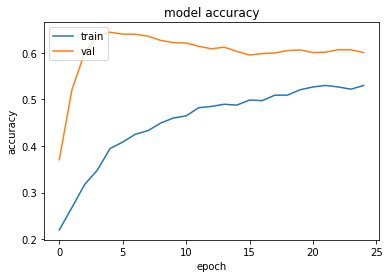

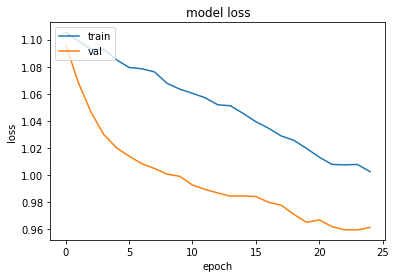

In [98]:
plot_model(em_lstm_hist)

In [99]:
def check_accuracy(model, X_test, y_test):
  test_sequences=token.texts_to_sequences(X_test)
  test_pad=sequence.pad_sequences(test_sequences, maxlen=max_seq_len)
  y_pred = model.predict(test_pad)
  acc=model.evaluate(test_pad, y_test)
  print("Accuracy: {}".format(acc[1]))
  y_test_=np.argmax(y_test, axis=1)
  y_pred=np.argmax(y_pred, axis=1)
  print(metrics.classification_report(y_test_, y_pred))
  cm = confusion_matrix(y_test_, y_pred, normalize='true')
  
  np.set_printoptions(precision=2)
  # cm = confusion_matrix(y_test, y_pred)gist_gray_r

  cm_display = ConfusionMatrixDisplay(cm, display_labels=label.values()).plot(cmap=plt.cm.Blues)

EM_LSTM accuracy hs: 
3718/3718 [==============================] - 1s 236us/step
Accuracy: 0.7167832255363464
              precision    recall  f1-score   support

           0       0.23      0.23      0.23       199
           1       0.90      0.75      0.82      2894
           2       0.40      0.72      0.52       625

    accuracy                           0.72      3718
   macro avg       0.51      0.56      0.52      3718
weighted avg       0.78      0.72      0.74      3718



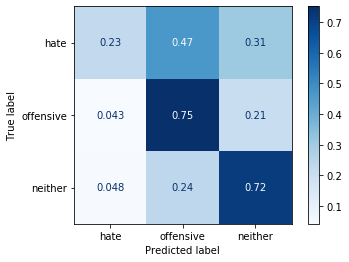

In [100]:
print("EM_LSTM accuracy hs: ")
check_accuracy(em_model, X_test, y_test)

In [107]:
_,__, X_test_padded, b = create_token(X_test, max_seq_len)
acc=em_model.evaluate(X_test_padded, y_test)
print("Accuracy: {}".format(acc[]))

3718/3718 [==============================] - 1s 221us/step


IndexError: list index out of range

In [108]:
acc

[0.9686730824984037,
 0.5917159914970398,
 0.18618425726890564,
 1.0,
 0.1032169908285141]

# Creating LSTM Model

In [714]:
def LSTM_model(max_words, max_phrase):
  model = Sequential()
  model.add(Embedding(input_dim = max_words, output_dim = 100, input_length = max_phrase))
  model.add(SpatialDropout1D(0.3))
  model.add(LSTM(128, dropout = 0.5, recurrent_dropout = 0.3))
#   model.add(BatchNormalization())  
  model.add(Dense(128, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(3, activation = 'softmax'))

  model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=1e-5),metrics=['accuracy'])
  
  model.summary()
  return model

class_weight = {0:0.65, 1: 0.10, 2:0.25}

In [153]:
def fit_model2(model, pad_sequence, callback):
  history = model.fit(pad_sequence, y_train, validation_data = (X_val_padded, y_val), epochs = 20, batch_size = 128, callbacks = [callback], class_weight = class_weight)
  return model, history


In [160]:
X_train_pad.shape

(16852, 34)

# Training LSTM Model

In [154]:
lstm_model = LSTM_model(len(word_index)+1, X_train_pad.shape[1])

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 34, 100)           1626500   
_________________________________________________________________
spatial_dropout1d_14 (Spatia (None, 34, 100)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dense_27 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 3)                 387       
Total params: 1,760,647
Trainable params: 1,760,647
Non-trainable params: 0
___________________________________________

In [155]:
# checkpoint_path = '/Users/ethan/py3tf/00checkpoint_play/cp-{epoch:04d}.ckpt'
# checkpoint_loc = os.path.dirname(checkpoint_path)
checkpoint_path = '/Users/ethan/py3tf/model_bestweight/lstm_hs_model_weights.h5'
checkpt = keras.callbacks.ModelCheckpoint(checkpoint_path,monitor='val_accuracy',save_weights_only=True,save_best_only=True,verbose=1)
# lstm_model2, lstm_hist2 = fit_model2(lstm_model, X_train_pad, checkpt)

In [156]:
lstm_model2, lstm_hist2 = fit_model2(lstm_model, X_train_pad, checkpt)

Train on 16852 samples, validate on 4213 samples
Epoch 1/20
16852/16852 [==============================] - 14s 849us/step - loss: 0.2108 - accuracy: 0.5507 - val_loss: 1.0797 - val_accuracy: 0.7774

Epoch 00001: val_accuracy improved from -inf to 0.77736, saving model to /Users/ethan/py3tf/model_bestweight/lstm_hs_model_weights.h5
Epoch 2/20
16852/16852 [==============================] - 13s 799us/step - loss: 0.2084 - accuracy: 0.7460 - val_loss: 1.0521 - val_accuracy: 0.7776

Epoch 00002: val_accuracy improved from 0.77736 to 0.77759, saving model to /Users/ethan/py3tf/model_bestweight/lstm_hs_model_weights.h5
Epoch 3/20
16852/16852 [==============================] - 13s 779us/step - loss: 0.2034 - accuracy: 0.7717 - val_loss: 0.9761 - val_accuracy: 0.7776

Epoch 00003: val_accuracy did not improve from 0.77759
Epoch 4/20
16852/16852 [==============================] - 13s 777us/step - loss: 0.1922 - accuracy: 0.7726 - val_loss: 0.8124 - val_accuracy: 0.7776

Epoch 00004: val_accuracy

In [147]:
# Loads best weights monitored on highest validation accuracy
lstm_model2.load_weights(checkpoint_path)

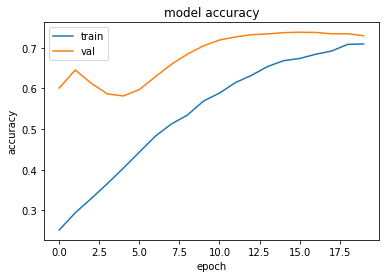

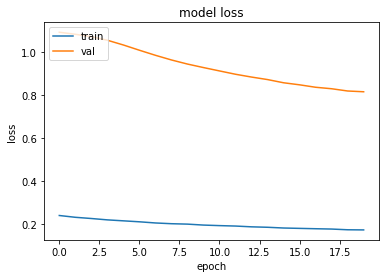

In [148]:
plot_model(lstm_hist2)

In [730]:
from sklearn import metrics

LSTM accuracy hs: 
3718/3718 [==============================] - 1s 227us/step
Accuracy: 0.787520170211792
              precision    recall  f1-score   support

           0       0.17      0.07      0.10       199
           1       0.82      0.94      0.88      2894
           2       0.57      0.30      0.39       625

    accuracy                           0.79      3718
   macro avg       0.52      0.44      0.46      3718
weighted avg       0.75      0.79      0.76      3718



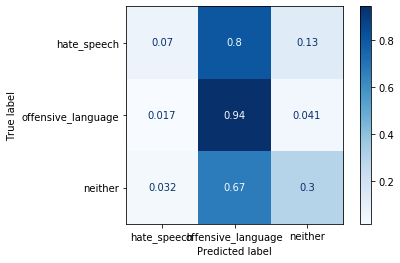

In [151]:
print("LSTM accuracy hs: ")
check_accuracy(lstm_model2, X_test, y_test)

In [ ]:
!pip install h5py pyyaml

In [650]:
# save_path = '/Users/ethan/py3tf'
# model_name = "lstm_sr_model.h5"
# model_hist = lstm_model.save(os.path.join(save_path,model_name))

In [ ]:
# from keras.models import load_model
# model2 = load_model(os.path.join(save_path,model_name))
# print("before change")
# print(model2.get_weights())
# checkpoint_loc ='/Users/ethan/py3tf/checkpoint_hs_sr/'
# model2.load_weights(os.path.join(checkpoint_loc,"cp-0001.ckpt"))
# print("after change")
# print(model2.get_weights())

In [ ]:
    
#   def focal_loss(gamma=2., alpha=4.):

#     gamma = float(gamma)
#     alpha = float(alpha)

#     def focal_loss_fixed(y_true, y_pred):
#         """Focal loss for multi-classification
#         FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
#         Notice: y_pred is probability after softmax
#         gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
#         d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
#         Focal Loss for Dense Object Detection
#         https://arxiv.org/abs/1708.02002

#         Arguments:
#             y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
#             y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

#         Keyword Arguments:
#             gamma {float} -- (default: {2.0})
#             alpha {float} -- (default: {4.0})

#         Returns:
#             [tensor] -- loss.
#         """
#         epsilon = 1.e-9
#         y_true = tf.convert_to_tensor(y_true, tf.float32)
#         y_pred = tf.convert_to_tensor(y_pred, tf.float32)

#         model_out = tf.add(y_pred, epsilon)
#         ce = tf.multiply(y_true, -tf.log(model_out))
#         weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
#         fl = tf.multiply(alpha, tf.multiply(weight, ce))
#         reduced_fl = tf.reduce_max(fl, axis=1)
#         return tf.reduce_mean(reduced_fl)
#     return focal_loss_fixed  
#   model.compile(loss=focal_loss(alpha=4), optimizer='nadam', metrics=['accuracy'])  

# CNN

In [75]:
# Creating CNN model

# Create embedding matrix for CNN
def index_vector():
  embeddings_index = {}
  f = open('/Users/ethan/py3tf/project_nlp/glove.6B/glove.6B.100d.txt', encoding='utf-8')
  for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
  f.close()
  return embeddings_index

def create_embed_matrix(word_index, embeddings_index):
  embedding_matrix = np.zeros((len(word_index) + 1, 100))
  for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
  return embedding_matrix



def cnn_model(nb_words, embedding_matrix, max_seq_len, num_classes=3):
  model = Sequential()
  embed_dim=100
  num_filters=64
  model.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len, trainable=True))
  model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
  model.add(MaxPooling1D(2))
  model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
  model.add(GlobalMaxPooling1D())
  model.add(Dropout(0.5))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(num_classes, activation='sigmoid'))  #multi-label (k-hot encoding)

  adam = optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
  model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
  model.summary()
  return model


def fit_model(model, pad_sequence, callback):
  history = model.fit(pad_sequence, y_train, validation_data = (X_val_padded, y_val), epochs = 10, batch_size = 128, callbacks = [callback])
  return model, history


# Train CNN

In [76]:
embeddings_index=index_vector()
embeddings_matrix=create_embed_matrix(word_index, embeddings_index)

100%|██████████| 35882/35882 [00:00<00:00, 557174.28it/s]


In [77]:

cnn_model = cnn_model(len(word_index)+1, embeddings_matrix, X_train_pad.shape[1])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 100)           3588300   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 50, 64)            44864     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 25, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 25, 64)            28736     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)               

In [78]:

checkpoint_path1 = '/Users/ethan/py3tf/00checkpoint_hs_sr_rs_rd_ri_cnn/cp-{epoch:04d}.ckpt'
checkpoint_loc1 = os.path.dirname(checkpoint_path1)
checkpt1 = keras.callbacks.ModelCheckpoint(checkpoint_path1,save_weights_only=True,verbose=1,period=1)

cnn_model, cnn_hist = fit_model(cnn_model, X_train_pad, checkpt1)

Train on 84260 samples, validate on 4213 samples
Epoch 1/10
84260/84260 [==============================] - 47s 559us/step - loss: 0.2287 - accuracy: 0.9088 - val_loss: 0.6163 - val_accuracy: 0.8009

Epoch 00001: saving model to /Users/ethan/py3tf/00checkpoint_hs_sr_rs_rd_ri_cnn/cp-0001.ckpt
Epoch 2/10
84260/84260 [==============================] - 48s 572us/step - loss: 0.1002 - accuracy: 0.9634 - val_loss: 0.8035 - val_accuracy: 0.8137

Epoch 00002: saving model to /Users/ethan/py3tf/00checkpoint_hs_sr_rs_rd_ri_cnn/cp-0002.ckpt
Epoch 3/10
84260/84260 [==============================] - 47s 555us/step - loss: 0.0505 - accuracy: 0.9816 - val_loss: 1.0879 - val_accuracy: 0.8193

Epoch 00003: saving model to /Users/ethan/py3tf/00checkpoint_hs_sr_rs_rd_ri_cnn/cp-0003.ckpt
Epoch 4/10
84260/84260 [==============================] - 47s 561us/step - loss: 0.0317 - accuracy: 0.9886 - val_loss: 1.1537 - val_accuracy: 0.8103

Epoch 00004: saving model to /Users/ethan/py3tf/00checkpoint_hs_sr_rs_rd

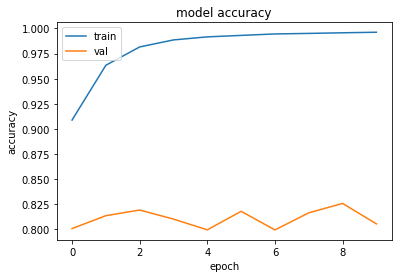

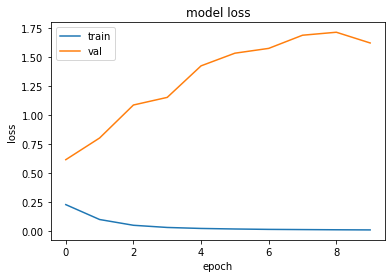

In [81]:
plt.plot(cnn_hist.history['accuracy'])
plt.plot(cnn_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(cnn_hist.history['loss'])
plt.plot(cnn_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

CNN accuracy : 
3718/3718 [==============================] - 0s 68us/step
Accuracy: 0.9159942269325256
              precision    recall  f1-score   support

           0       0.33      0.32      0.32       199
           1       0.91      0.94      0.93      2894
           2       0.84      0.73      0.78       625

    accuracy                           0.87      3718
   macro avg       0.70      0.66      0.68      3718
weighted avg       0.87      0.87      0.87      3718



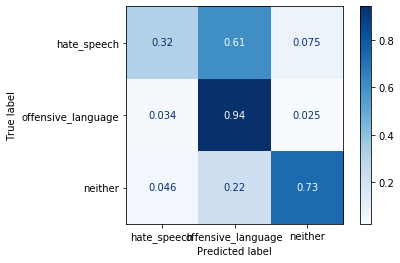

In [82]:
print("CNN accuracy : ")
check_accuracy(cnn_model, X_test, y_test)

In [53]:
save_path = '/Users/ethan/py3tf'
model_name = "cnn_sr_rs_rd_ri_model.h5"
model_hist = lstm_model.save(os.path.join(save_path,model_name))

# Regression

In [83]:
text_transformer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), lowercase=True, max_features=10000)

X_train_text = text_transformer.fit_transform(X_train)
X_test_text = text_transformer.transform(X_test)

logit = LogisticRegression(C=5, solver='lbfgs', multi_class='multinomial', random_state=17, n_jobs=4)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

y_train_org = np.argmax(y_train, axis=1)
y_test_org = np.argmax(y_test, axis=1)

cv_results = cross_val_score(logit, X_train_text, y_train_org, cv=skf, scoring='f1_micro')
logit.fit(X_train_text, y_train_org)

LogisticRegression(C=5, multi_class='multinomial', n_jobs=4, random_state=17)

Logistic regression accuracy : 
              precision    recall  f1-score   support

           0       0.44      0.26      0.33       199
           1       0.91      0.96      0.93      2894
           2       0.84      0.76      0.80       625

    accuracy                           0.89      3718
   macro avg       0.73      0.66      0.69      3718
weighted avg       0.87      0.89      0.88      3718



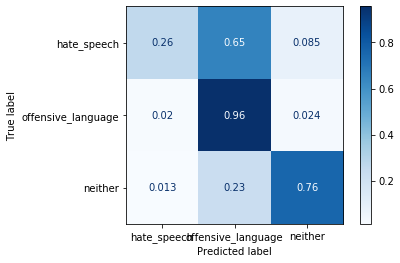

In [84]:
print("Logistic regression accuracy : ")
logit.score(X_test_text, y_test_org)
y_pred = logit.predict(X_test_text)
y_test_=np.argmax(y_test, axis=1)
print(metrics.classification_report(y_test_, y_pred))
cm = confusion_matrix(y_test_, y_pred, normalize='true')

np.set_printoptions(precision=2)
# cm = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm, display_labels=label.values()).plot(cmap=plt.cm.Blues)